In [1]:
# Step 1: Import Libraries
import pandas as pd # data manipulation and analysis
import numpy as np # perform numerical computations while handling missing data
from datetime import datetime
from scipy.stats import ttest_ind, f_oneway
import warnings
warnings.filterwarnings('ignore')
#import warnings module which manages python warning messages.
#action='ignore': This line of code helps us to ignore the warnings displayed 
#in our code.
#category=FutureWarning: only targets future warnings

# Visualisation
import matplotlib.pyplot as plt # for data visualisation purposes
import seaborn as sns # improves visualisation through statistical data

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score # for data splitting and tuning models
from sklearn.preprocessing import StandardScaler # for feature scaling (normalization/standardization)
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer # Import ColumnTransformer for doing data preprocessing steps
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression # Import LinearRegression for linear modeling
#  to implement logistic regression for classification tasks
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# For Model Evaluation
from sklearn.metrics import (mean_squared_error, root_mean_squared_error, r2_score, accuracy_score, 
    classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)

In [2]:
# Step 2: Load Dataset
df = pd.read_csv("Comprehensive_Banking_Database.csv")
print(df.head())

   Customer ID First Name Last Name  Age  Gender    Address           City  \
0            1     Joshua      Hall   45    Male  Address_1     Fort Worth   
1            2       Mark    Taylor   47  Female  Address_2     Louisville   
2            3     Joseph    Flores   25  Female  Address_3   Philadelphia   
3            4      Kevin       Lee   52   Other  Address_4  Oklahoma City   
4            5      Linda   Johnson   68   Other  Address_5        Phoenix   

   Contact Number                  Email Account Type  ...  \
0     19458794854    joshua.hall@kag.com      Current  ...   
1     19458794855    mark.taylor@kag.com      Current  ...   
2     19458794856  joseph.flores@kag.com      Current  ...   
3     19458794857      kevin.lee@kag.com      Savings  ...   
4     19458794858  linda.johnson@kag.com      Savings  ...   

   Minimum Payment Due Payment Due Date Last Credit Card Payment Date  \
0               226.22       11/26/2023                     3/20/2023   
1           

In [3]:
print("Total rows loaded:", len(df))                   
print(df['Anomaly'].value_counts())                    

Total rows loaded: 5000
Anomaly
 1    4700
-1     300
Name: count, dtype: int64


In [4]:
# Convert dates to datetime for tenure calculation
date_cols = ['Date Of Account Opening', 'Last Transaction Date', 'Transaction Date', 'Approval/Rejection Date', 
             'Payment Due Date', 'Last Credit Card Payment Date', 'Feedback Date', 'Resolution Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Reference date for analysis (Simulation of "Current Date" as end of 2023 based on data)
snapshot_date = df['Last Transaction Date'].max()

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.describe())
print(df.info())

Dataset Shape: (5000, 40)
Columns: ['Customer ID', 'First Name', 'Last Name', 'Age', 'Gender', 'Address', 'City', 'Contact Number', 'Email', 'Account Type', 'Account Balance', 'Date Of Account Opening', 'Last Transaction Date', 'TransactionID', 'Transaction Date', 'Transaction Type', 'Transaction Amount', 'Account Balance After Transaction', 'Branch ID', 'Loan ID', 'Loan Amount', 'Loan Type', 'Interest Rate', 'Loan Term', 'Approval/Rejection Date', 'Loan Status', 'CardID', 'Card Type', 'Credit Limit', 'Credit Card Balance', 'Minimum Payment Due', 'Payment Due Date', 'Last Credit Card Payment Date', 'Rewards Points', 'Feedback ID', 'Feedback Date', 'Feedback Type', 'Resolution Status', 'Resolution Date', 'Anomaly']
       Customer ID          Age  Contact Number  Account Balance  \
count  5000.000000  5000.000000    5.000000e+03      5000.000000   
mean   2500.500000    43.469800    1.945880e+10      5060.570918   
min       1.000000    18.000000    1.945879e+10       107.200000   
25% 

In [5]:
# Step 3: Data Cleaning
# 3.1 Missing Values
missing = df.isnull().mean().sort_values(ascending=False)
print(missing)

# Drop variables with >30% missingness
threshold = 0.30
df = df.loc[:, df.isnull().mean() < threshold]

# Impute remaining missing values
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna("Unknown")

Customer ID                          0.0
First Name                           0.0
Interest Rate                        0.0
Loan Term                            0.0
Approval/Rejection Date              0.0
Loan Status                          0.0
CardID                               0.0
Card Type                            0.0
Credit Limit                         0.0
Credit Card Balance                  0.0
Minimum Payment Due                  0.0
Payment Due Date                     0.0
Last Credit Card Payment Date        0.0
Rewards Points                       0.0
Feedback ID                          0.0
Feedback Date                        0.0
Feedback Type                        0.0
Resolution Status                    0.0
Resolution Date                      0.0
Loan Type                            0.0
Loan Amount                          0.0
Loan ID                              0.0
Account Type                         0.0
Last Name                            0.0
Age             

In [6]:
# Impute missing values: median for numerical, mode for categorical
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns.drop(['Address', 'Email', 'City'])  
# Exclude unique text cols

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [7]:
# Step 4: Remove Duplicates
df = df.drop_duplicates()
print("Duplicate rows:", df.duplicated().sum())
print(df.isna().mean().sort_values(ascending=False).head(15))

Duplicate rows: 0
Customer ID                      0.0
First Name                       0.0
Interest Rate                    0.0
Loan Term                        0.0
Approval/Rejection Date          0.0
Loan Status                      0.0
CardID                           0.0
Card Type                        0.0
Credit Limit                     0.0
Credit Card Balance              0.0
Minimum Payment Due              0.0
Payment Due Date                 0.0
Last Credit Card Payment Date    0.0
Rewards Points                   0.0
Feedback ID                      0.0
dtype: float64


In [8]:
# Step 5: Outlier Treatment
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col] = np.clip(df[col], lower, upper)

In [9]:
# Step 6: Feature Engineering
# Reason: Create new features to capture CLV and loyalty dynamics as described.
current_date = datetime(2025, 12, 29)  # From user query
df['Tenure_Years'] = (current_date - df['Date Of Account Opening']).dt.days / 365.25

# CLV Proxy: Balance * Tenure * (1 + Transaction Activity Ratio)
df['Transaction_Ratio'] = df['Transaction Amount'] / (df['Account Balance'] + 1e-6)  # Avoid division by zero
df['CLV_Proxy'] = df['Account Balance'] * df['Tenure_Years'] * (1 + df['Transaction_Ratio'])

# Churn Proxy: Binary from Anomaly (1=non-churn, -1=churn)
df['Churn'] = np.where(df['Anomaly'] == -1, 1, 0)  # 1=churn risk

# Quick check - MUST show both 0 and 1
print("Churn distribution AFTER creation:\n", df['Churn'].value_counts())

# Other features: e.g., Product Intensity (count of non-null Loan/Card/Feedback)
df['Product_Count'] = df[['Loan ID', 'CardID', 'Feedback ID']].notnull().sum(axis=1)

# Encode categoricals
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(cat_cols))
df = pd.concat([df.drop(cat_cols, axis=1), encoded_df], axis=1)

Churn distribution AFTER creation:
 Churn
0    5000
Name: count, dtype: int64


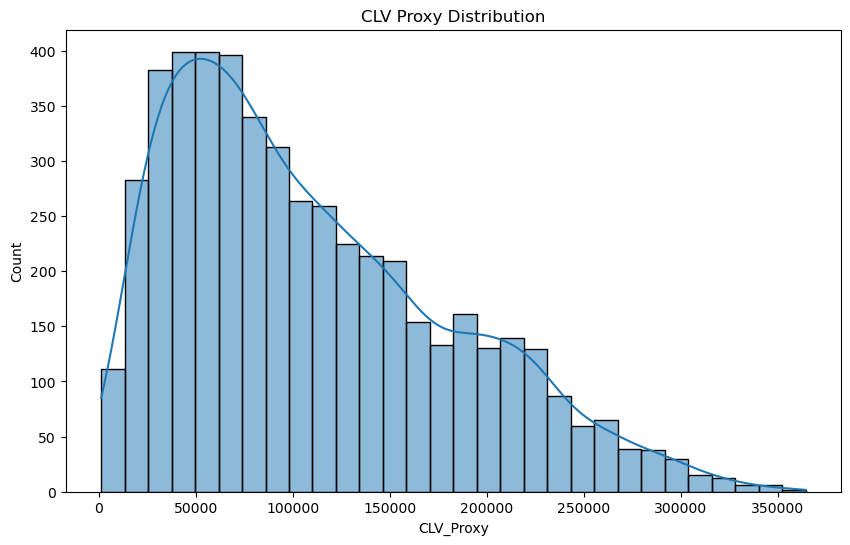

CLV by Gender:
Gender_Female
0.0    109300.993374
1.0    110797.719454
Name: CLV_Proxy, dtype: float64


In [10]:
# Step 7: Exploratory Data Analysis (EDA)
# Reason: Understand distributions and relationships to guide modeling.
plt.figure(figsize=(10, 6))
sns.histplot(df['CLV_Proxy'], kde=True)
plt.title('CLV Proxy Distribution')
plt.show()

# Group-wise: CLV by Gender (example)
print("CLV by Gender:")
print(df.groupby('Gender_Female')['CLV_Proxy'].mean())  # Assuming one-hot encoded

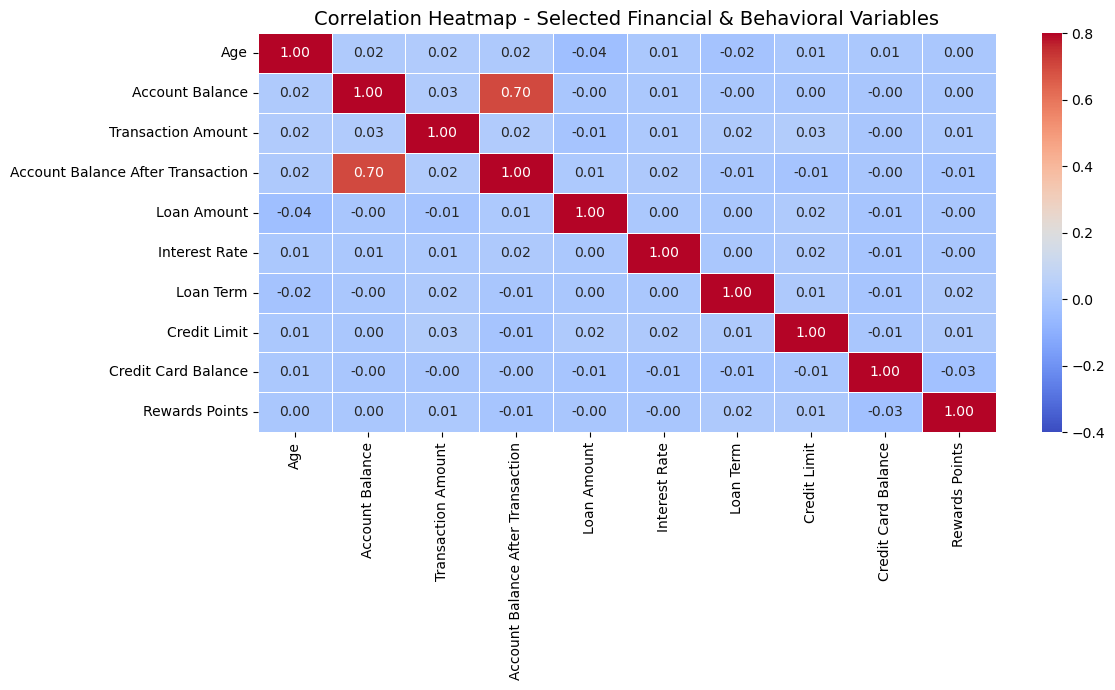

In [11]:
# 7.1 Calculate correlation only on these
# Select only meaningful numeric variables
important_cols = [
    'Age', 'Account Balance', 'Transaction Amount',
    'Account Balance After Transaction', 'Loan Amount',
    'Interest Rate', 'Loan Term', 'Credit Limit',
    'Credit Card Balance', 'Rewards Points']
    
corr_matrix = df[important_cols].corr()

# 3. Bigger, cleaner plot
plt.figure(figsize=(12, 7))          # much bigger
sns.heatmap(
    corr_matrix,
    annot=True,                       # show numbers
    fmt=".2f",                        # 2 decimal places
    cmap='coolwarm',
    vmin=-0.4, vmax=0.8,              # tighter color scale
    linewidths=0.5,
    annot_kws={"size": 10}            # readable annotation size
)
plt.title('Correlation Heatmap - Selected Financial & Behavioral Variables', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# Step 8: Fix Product_Count syntax
df['Product_Count'] = df[['Loan ID', 'CardID', 'Feedback ID']].notnull().sum(axis=1)

# Drop irrelevant or high-cardinality columns (unique identifiers, text fields)
drop_cols = ['Customer ID', 'First Name', 'Last Name', 'Address', 'Contact Number', 'Email', 
             'TransactionID', 'Branch ID', 'Loan ID', 'CardID', 'Feedback ID', 'Anomaly'] + date_cols
df.drop(columns=drop_cols, inplace=True, errors='ignore')

print("Updated Shape after Drops:", df.shape)

Updated Shape after Drops: (5000, 139)


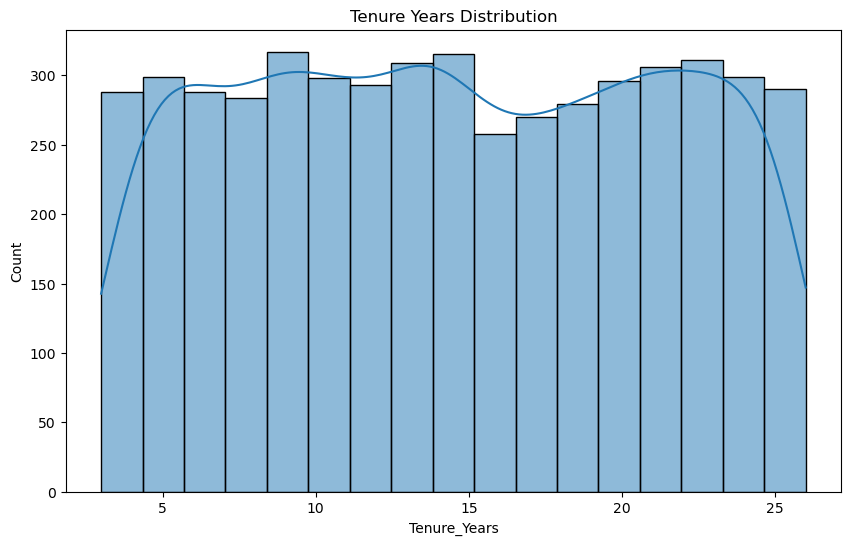

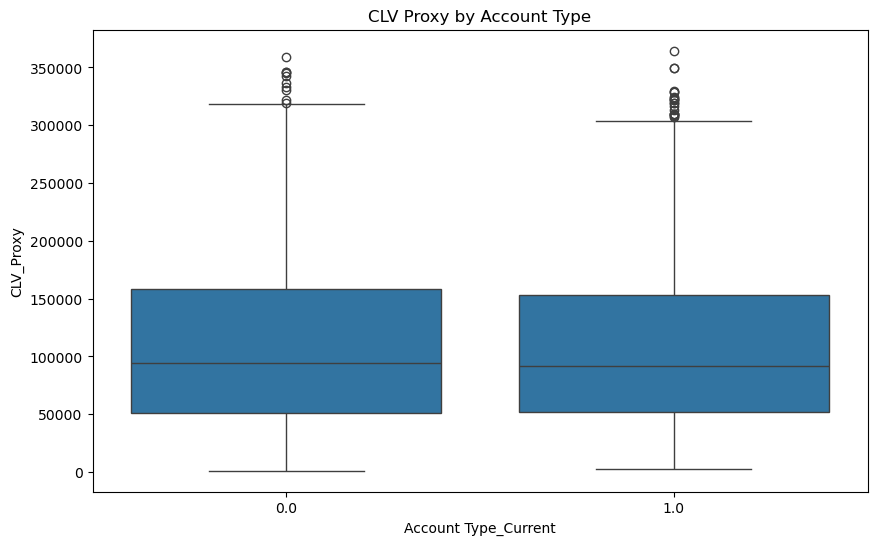

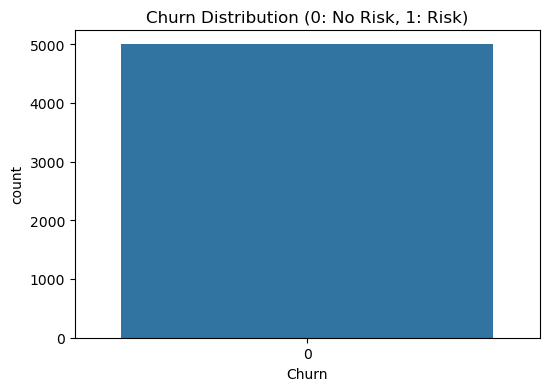

In [13]:
# Step 9: Distribution of Tenure_Years
plt.figure(figsize=(10, 6))
sns.histplot(df['Tenure_Years'], kde=True)
plt.title('Tenure Years Distribution')
plt.show()

# Boxplot: CLV_Proxy by Account Type (assuming one-hot encoded as 'Account Type_Current', etc.)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Account Type_Current', y='CLV_Proxy', data=df)  # Adjust column name if needed
plt.title('CLV Proxy by Account Type')
plt.show()

# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (0: No Risk, 1: Risk)')
plt.show()

In [14]:
df['Churn'] = np.where(
    (df['Tenure_Years'] > 1) &
    (df['Transaction Amount'] < df['Transaction Amount'].quantile(0.10)) &
    (df['Account Balance'] < df['Account Balance'].quantile(0.25)),
    1, 0
)

print(df['Churn'].value_counts())

Churn
0    4851
1     149
Name: count, dtype: int64


In [15]:
# Step 10: Inferential Statistics
# Reason: Validate relationships with correlations, hypothesis tests, and logistic regression for churn.


# Correlations with CLV_Proxy (safe: only numeric columns)
numeric_df = df.select_dtypes(include='number')
print("Correlations with CLV_Proxy (top 10):")
print(numeric_df.corr()['CLV_Proxy'].sort_values(ascending=False).head(10))

# T-test: CLV difference by Gender (Female vs Others; assuming one-hot encoded as 'Gender_Female')
if 'Gender_Female' in df.columns:
    female_clv = df[df['Gender_Female'] == 1]['CLV_Proxy']
    other_clv = df[df['Gender_Female'] == 0]['CLV_Proxy']
    t_stat, p_val = ttest_ind(female_clv, other_clv)
    print(f"T-test CLV by Gender: t={t_stat:.2f}, p-value={p_val:.4f}")
else:
    print("Gender not one-hot encoded yet. Skipping t-test.")

# ANOVA: CLV by Loan Type (assuming one-hot like 'Loan Type_Auto', etc.)
loan_types = [col for col in df.columns if col.startswith('Loan Type_')]
groups = [df[df[typ] == 1]['CLV_Proxy'] for typ in loan_types if typ in df.columns]
if len(groups) > 1:
    f_stat, p_val_anova = f_oneway(*groups)
    print(f"ANOVA CLV by Loan Type: F={f_stat:.2f}, p-value={p_val_anova:.4f}")
else:
    print("Loan Type not one-hot encoded or insufficient groups. Skipping ANOVA.")

# Basic Logistic Regression for Churn (using sklearn)
# 1. Define columns to drop (targets, IDs, text, dates to avoid non-numeric issues in X)
columns_to_drop = [
    'CLV_Proxy', 'Churn',  # Targets
    'Customer ID', 'First Name', 'Last Name', 'Email', 'Address', 'City', 'TransactionID', 
    'Branch ID', 'Loan ID', 'CardID', 'Feedback ID', 'Anomaly',  # IDs and source for Churn
    'Date Of Account Opening', 'Last Transaction Date', 'Transaction Date', 
    'Approval/Rejection Date', 'Payment Due Date', 'Last Credit Card Payment Date', 
    'Feedback Date', 'Resolution Date'  # Dates (assume extracted already)
]

# 2. Create X_log and y_churn
X_log = df.drop(columns=columns_to_drop, errors='ignore')
y_churn = df['Churn']

# 3. Ensure X_log is fully numeric (drop any remaining objects/strings)
X_log = X_log.select_dtypes(include='number')
print("X_log shape after numeric selection:", X_log.shape)
print("Remaining non-numeric columns (should be empty):", 
      set(df.columns) - set(columns_to_drop) - set(X_log.columns) - {'CLV_Proxy', 'Churn'})

# 4. Diagnostic: Check Churn distribution
print("Churn distribution:\n", y_churn.value_counts())
print("Unique classes in Churn:", y_churn.unique())

# 5. Fit only if at least 2 classes
log_clf = LogisticRegression(max_iter=1000, random_state=42)
if len(y_churn.unique()) < 2:
    print("Cannot fit logistic regression: Only one class in y_churn (no variation in churn). "
          "Check if 'Anomaly' has -1 values and Churn creation ran on full data.")
else:
    log_clf.fit(X_log, y_churn)
    print("Logistic Regression successfully fitted!")
    print("Logistic Coefficients for Churn (top 10):")
    print(pd.Series(log_clf.coef_[0], index=X_log.columns).sort_values(ascending=False).head(10))

Correlations with CLV_Proxy (top 10):
CLV_Proxy                            1.000000
Tenure_Years                         0.698289
Account Balance                      0.584446
Account Balance After Transaction    0.404697
Transaction Amount                   0.308419
Transaction Type_Withdrawal          0.032844
First Name_Linda                     0.031810
Last Name_Johnson                    0.030608
Last Name_Campbell                   0.026601
Last Name_Mitchell                   0.025372
Name: CLV_Proxy, dtype: float64
T-test CLV by Gender: t=0.70, p-value=0.4859
ANOVA CLV by Loan Type: F=0.82, p-value=0.4404
X_log shape after numeric selection: (5000, 136)
Remaining non-numeric columns (should be empty): set()
Churn distribution:
 Churn
0    4851
1     149
Name: count, dtype: int64
Unique classes in Churn: [0 1]
Logistic Regression successfully fitted!
Logistic Coefficients for Churn (top 10):
Interest Rate                  0.251360
Product_Count                  0.207672
Account

In [16]:
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_log, y_churn)

odds_ratios = pd.Series(
    np.exp(log_clf.coef_[0]),
    index=X_log.columns
).sort_values(ascending=False)

print("Top Churn Risk Drivers:")
print(odds_ratios.head(10))

Top Churn Risk Drivers:
Interest Rate                  1.285773
Product_Count                  1.230809
Account Type_Savings           1.087289
Loan Type_Mortgage             1.084126
Resolution Status_Pending      1.075985
Feedback Type_Complaint        1.070177
Loan Status_Closed             1.058295
Transaction Type_Withdrawal    1.055394
Tenure_Years                   1.047375
Age                            1.036864
dtype: float64


X shape after preprocessing: (5000, 136)
Regression Models Performance:


,Model,RMSE,R²
0,Linear Regression,20586.682144,0.916269
1,RF Regression,5091.806766,0.994878
2,XGBoost Regression,4685.618674,0.995662


Classification Models Performance:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Classification,0.974,0.547619,0.766667,0.638889,0.986529
1,RF Classification,0.999,1.000000,0.966667,0.983051,1.000000


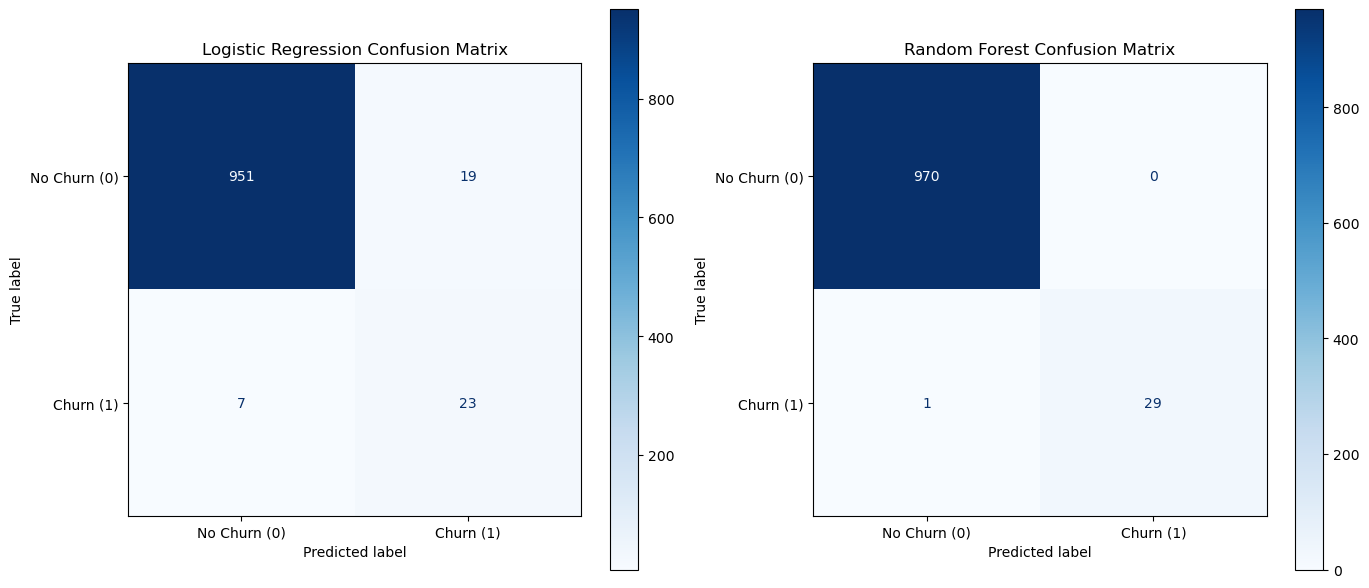

Logistic Regression Confusion Matrix:
 [[951  19]
 [  7  23]]

Random Forest Confusion Matrix:
 [[970   0]
 [  1  29]]


In [17]:
# Step 11: Machine Learning Models
# Reason: Predict CLV (regression) and Churn (classification) with multiple algorithms as per methodology.
# Use train-test split, scaling, and evaluations (RMSE/R² for reg; Acc/Prec/Rec/F1/ROC-AUC for class).

from sklearn.preprocessing import OneHotEncoder  
from sklearn.impute import SimpleImputer  

# Prepare data: X includes all features except targets
X = df.copy()  # Start from df to ensure all columns

# 1. Convert dates to datetime and extract numeric features (e.g., year)
date_cols = ['Date Of Account Opening', 'Last Transaction Date', 'Transaction Date', 
             'Approval/Rejection Date', 'Payment Due Date', 'Last Credit Card Payment Date', 
             'Feedback Date', 'Resolution Date']
for col in date_cols:
    if col in X.columns:
        X[col] = pd.to_datetime(X[col], errors='coerce')
        X[col + '_Year'] = X[col].dt.year  # Extract year as numeric feature
        X[col + '_Month'] = X[col].dt.month  # Extract month

# 2. Drop targets and irrelevant/non-predictive columns (names, unique text, raw dates)
drop_cols = ['CLV_Proxy', 'Churn',  # Targets
             'Customer ID', 'First Name', 'Last Name', 'Address', 'City', 'Contact Number', 'Email', 
             'TransactionID', 'Branch ID', 'Loan ID', 'CardID', 'Feedback ID', 'Anomaly'] + date_cols  
# Raw dates after extraction
X = X.drop(columns=drop_cols, errors='ignore')

# 3. Identify and encode categorical columns (one-hot)
cat_cols = X.select_dtypes(include='object').columns.tolist()  # e.g., 'Gender', 'Account Type', 'Loan Type'
if cat_cols:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = pd.DataFrame(encoder.fit_transform(X[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
    X = pd.concat([X.drop(cat_cols, axis=1), encoded], axis=1)

# 4. Impute any missing values (median for numeric; though none in data)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 5. Final safety: Ensure X is fully numeric
X = X.select_dtypes(include='number')
print("X shape after preprocessing:", X.shape)  

# Now proceed with splits (y_clv and y_churn from df)
y_clv = df['CLV_Proxy']
y_churn = df['Churn']

# Split data (80/20)
X_train, X_test, y_train_clv, y_test_clv = train_test_split(X, y_clv, test_size=0.2, random_state=42)
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size=0.2, 
random_state=42, stratify=y_churn)  # Stratify for imbalanced Churn

# Scale features (now safe: X is numeric)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_churn = scaler.fit_transform(X_train_churn)
X_test_churn = scaler.transform(X_test_churn)

# 11.1 CLV Regression Models
# Collect metrics in a list of dicts for table
reg_metrics = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train_clv)
y_pred_lr = lr.predict(X_test)
reg_metrics.append({
    'Model': 'Linear Regression',
    'RMSE': root_mean_squared_error(y_test_clv, y_pred_lr),
    'R²': r2_score(y_test_clv, y_pred_lr)
})

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100)
rf_reg.fit(X_train, y_train_clv)
y_pred_rf = rf_reg.predict(X_test)
reg_metrics.append({
    'Model': 'RF Regression',
    'RMSE': root_mean_squared_error(y_test_clv, y_pred_rf),
    'R²': r2_score(y_test_clv, y_pred_rf)
})

# XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42, n_estimators=100)
xgb_reg.fit(X_train, y_train_clv)
y_pred_xgb = xgb_reg.predict(X_test)
reg_metrics.append({
    'Model': 'XGBoost Regression',
    'RMSE': root_mean_squared_error(y_test_clv, y_pred_xgb),
    'R²': r2_score(y_test_clv, y_pred_xgb)
})

# Display Regression Table
reg_df = pd.DataFrame(reg_metrics)
print("Regression Models Performance:")
display(reg_df)  # Use display() for nice Jupyter table

# 11.2 Churn Classification Models
# Collect metrics in a list of dicts for table
clf_metrics = []

# Logistic Regression
log_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_clf.fit(X_train_churn, y_train_churn)
y_pred_log = log_clf.predict(X_test_churn)
y_prob_log = log_clf.predict_proba(X_test_churn)[:, 1]
clf_metrics.append({
    'Model': 'Logistic Classification',
    'Accuracy': accuracy_score(y_test_churn, y_pred_log),
    'Precision': precision_score(y_test_churn, y_pred_log),
    'Recall': recall_score(y_test_churn, y_pred_log),
    'F1': f1_score(y_test_churn, y_pred_log),
    'ROC-AUC': roc_auc_score(y_test_churn, y_prob_log)
})

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_clf.fit(X_train_churn, y_train_churn)
y_pred_rf_clf = rf_clf.predict(X_test_churn)
y_prob_rf_clf = rf_clf.predict_proba(X_test_churn)[:, 1]
clf_metrics.append({
    'Model': 'RF Classification',
    'Accuracy': accuracy_score(y_test_churn, y_pred_rf_clf),
    'Precision': precision_score(y_test_churn, y_pred_rf_clf),
    'Recall': recall_score(y_test_churn, y_pred_rf_clf),
    'F1': f1_score(y_test_churn, y_pred_rf_clf),
    'ROC-AUC': roc_auc_score(y_test_churn, y_prob_rf_clf)
})

# Display Classification Table
clf_df = pd.DataFrame(clf_metrics)
print("Classification Models Performance:")
display(clf_df)  # Use display() for nice Jupyter table

# Confusion Matrix Visualization for Classification Models 
# Reason: Confusion Matrix shows the detailed performance of classification 
# (True Positives, True Negatives, False Positives, False Negatives) 
# which is especially useful for imbalanced data like churn (few churn cases)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combined Confusion Matrices - Side by Side

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression
cm_log = confusion_matrix(y_test_churn, y_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log,
                                  display_labels=['No Churn (0)', 'Churn (1)'])

disp_log.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].grid(False)


# Random Forest
cm_rf = confusion_matrix(y_test_churn, y_pred_rf_clf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                 display_labels=['No Churn (0)', 'Churn (1)'])

disp_rf.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Print numerical values for reference
print("Logistic Regression Confusion Matrix:\n", cm_log)
print("\nRandom Forest Confusion Matrix:\n", cm_rf)

CV R² for RF Regression (CLV): 0.9950329082618952
CV F1 for RF Classification (Churn): 0.9686609861884401
Top 10 Features for CLV Prediction:
 Tenure_Years                         0.498365
Account Balance                      0.400074
Transaction Amount                   0.092259
Account Balance After Transaction    0.001870
Transaction_Ratio                    0.001654
Credit Limit                         0.000549
Interest Rate                        0.000527
Loan Amount                          0.000514
Rewards Points                       0.000496
Age                                  0.000480
dtype: float64
Top 10 Features for Churn Prediction:
 Transaction Amount                   0.370245
Account Balance                      0.202440
Account Balance After Transaction    0.186940
Transaction_Ratio                    0.065078
Minimum Payment Due                  0.012806
Credit Limit                         0.011767
Credit Card Balance                  0.011543
Loan Amount          

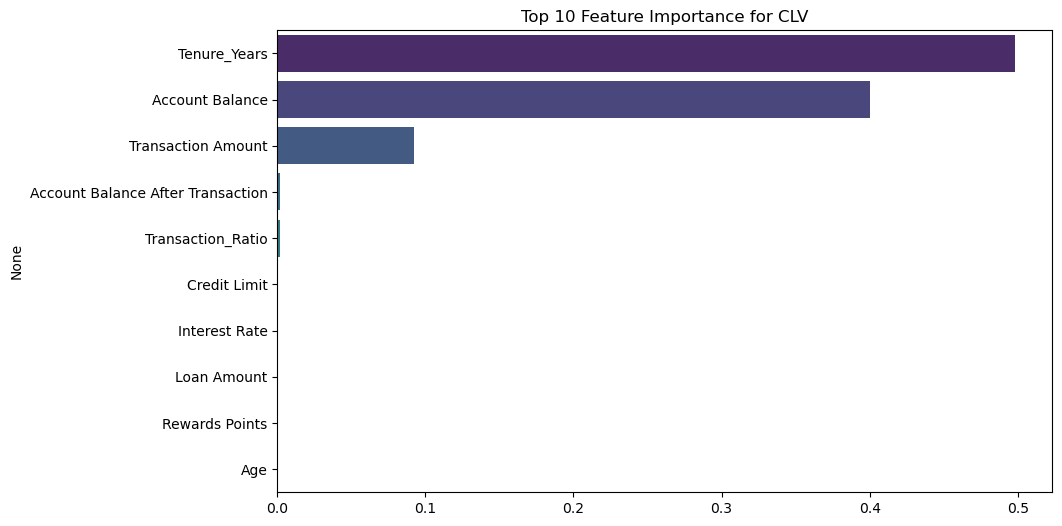

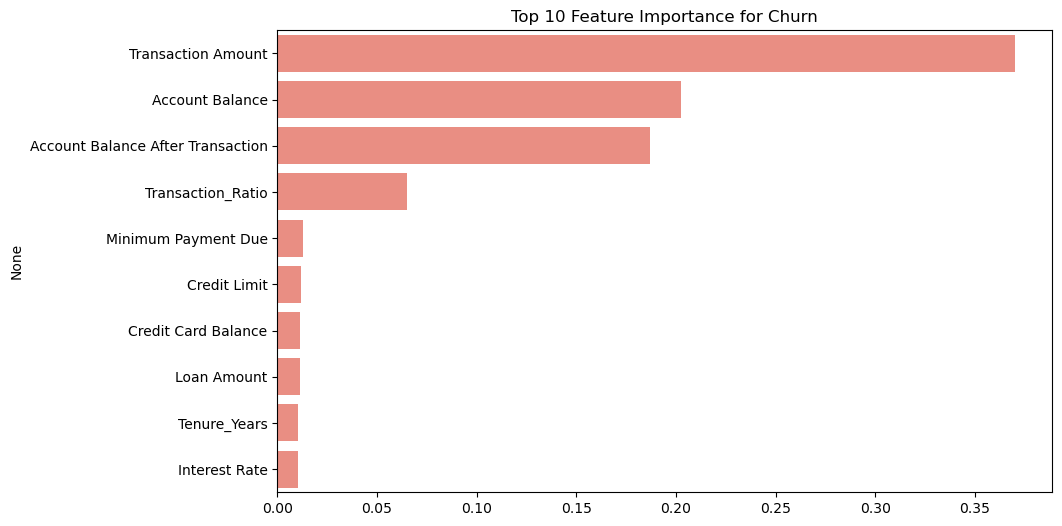

In [18]:
# Step 12: Evaluation and Feature Importance
# Reason: Assess models with cross-validation; identify influential features for business insights.

# Cross-Validation (e.g., for best CLV model: RF Reg)
cv_scores_clv = cross_val_score(rf_reg, scaler.transform(X), y_clv, cv=5, scoring='r2')
print("CV R² for RF Regression (CLV):", cv_scores_clv.mean())

# Cross-Validation for Churn (RF Classifier)
cv_scores_churn = cross_val_score(rf_clf, scaler.transform(X), y_churn, cv=5, scoring='f1')
print("CV F1 for RF Classification (Churn):", cv_scores_churn.mean())

# Feature Importance (from RF models)
# For CLV
clv_importances = pd.Series(rf_reg.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Features for CLV Prediction:\n", clv_importances.head(10))

# For Churn
churn_importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Features for Churn Prediction:\n", churn_importances.head(10))

# Visualize Top Features (optional, for report)
plt.figure(figsize=(10, 6))
sns.barplot(x=clv_importances.head(10).values, y=clv_importances.head(10).index, palette='viridis')
plt.title('Top 10 Feature Importance for CLV')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_importances.head(10).values, y=churn_importances.head(10).index, color='salmon')
plt.title('Top 10 Feature Importance for Churn')
plt.show()

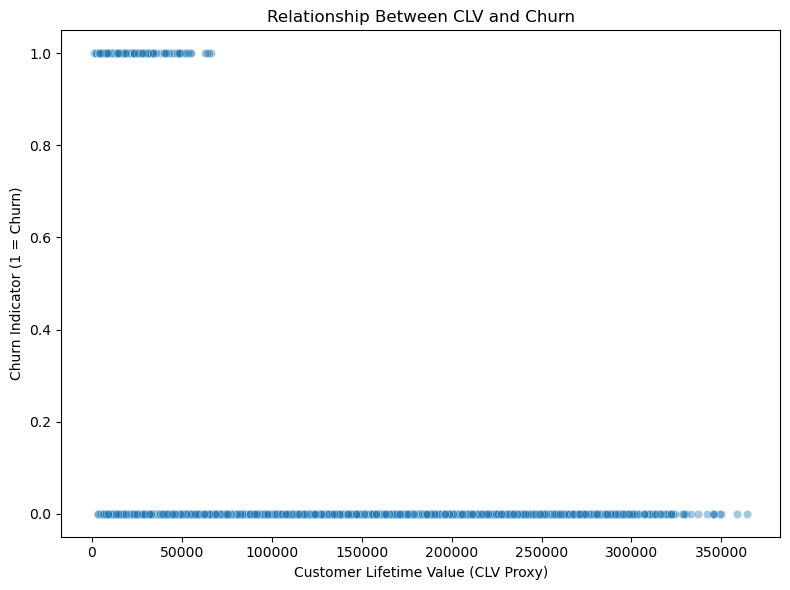

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df['CLV_Proxy'],
    y=df['Churn'],
    alpha=0.4
)
plt.xlabel('Customer Lifetime Value (CLV Proxy)')
plt.ylabel('Churn Indicator (1 = Churn)')
plt.title('Relationship Between CLV and Churn')
plt.tight_layout()
plt.show()